In [1]:
%load_ext autoreload
%autoreload 2
from targets.density_estimation_target import *

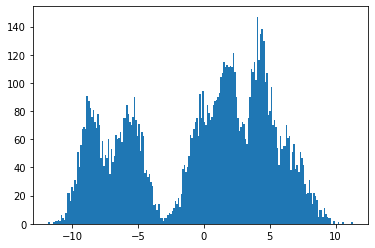

In [2]:
target = Dimension1()
data = target.sample(10000)
fig = plt.hist(data.numpy(), bins = 200)
plt.show()

In [3]:
from models_dif import DIFDensityEstimator
architecture = DIFDensityEstimator
structure = 10

In [4]:
from prettytable import PrettyTable

def count_parameters(structure):
    model = architecture(data, structure)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters(structure)
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     10     |
|  w.f.0.bias  |     10     |
|     T.m      |     10     |
|   T.log_s    |     10     |
+--------------+------------+
Total Trainable Params: 40
40


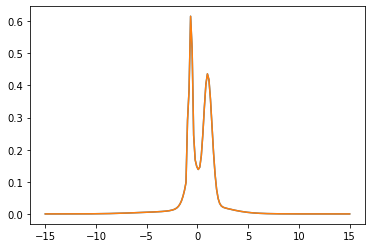

In [5]:
def from_phi_to_model(phi, dummy_model):
    current = 0
    for name, param in dummy_model.state_dict().items():
        num_element = param.numel()
        param_to_set = phi[current:current+num_element].reshape(param.shape)
        current += num_element
        param.copy_(param_to_set)
    return dummy_model

def from_model_to_phi(model):
    phi = []
    for name, param in model.state_dict().items():
        phi+=(list(param.flatten()))
    return torch.stack(phi, dim=-1)

def compute_log_p_phi_D(phi):
    model = architecture(data, structure)
    list_log_prob =[]
    for i in range(phi.shape[0]):
        phi_i = phi[i,:]
        model = from_phi_to_model(phi_i, dummy_model)
        list_log_prob.append(torch.sum(model.log_density(data), dim= 0))
    return torch.stack(list_log_prob) #+ MultivariateNormal(torch.zeros(phi.shape[1]), torch.eye(phi.shape[1])).log_prob(phi)


T = 25
N = 2
phi0 = torch.randn(N, number_param)
w0 =torch.ones(N)/N
def interpolation(t, target_log_density):
    return lambda samples : (1-t/(T-1))*MultivariateNormal(torch.zeros(number_param), torch.eye(number_param)).log_prob(samples) + t/(T-1)*target_log_density(samples)

target_log_densities = [interpolation(t, compute_log_p_phi_D) for t in range(T)]


dummy_model = architecture(data, structure)
model = from_phi_to_model(phi0[0], dummy_model)
linspace = torch.linspace(-15.,15., 200)
plt.plot(linspace, torch.exp(model.log_density(linspace.unsqueeze(-1))).detach().numpy())
phi_0_prime = from_model_to_phi(model)
model_prime = from_phi_to_model(phi_0_prime, dummy_model)
linspace = torch.linspace(-15.,15., 200)
plt.plot(linspace, torch.exp(model_prime.log_density(linspace.unsqueeze(-1))).detach().numpy())

In [6]:
model_train = architecture(data,structure)
model_train.train(epochs = 500)
phi_0 = from_model_to_phi(model_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:12<00:00,  6.89it/s, cpu]


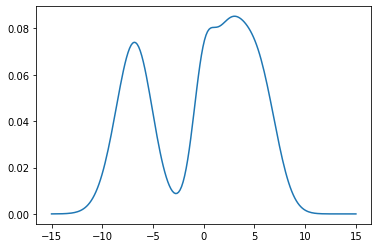

In [7]:
linspace = torch.linspace(-15.,15., 200)
plt.plot(linspace, torch.exp(model_train.log_density(linspace.unsqueeze(-1))).detach().numpy())

In [8]:
from sequential_sampler import SMCSampler2
smc = SMCSampler2(target_log_densities, phi0, w0)
smc.sample()
samples = smc.particles[-1]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:37<00:00,  9.08s/it]


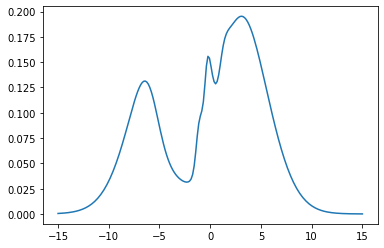

In [9]:
from IPython.display import clear_output
linspace = torch.linspace(-15.,15., 200)
sum_density = torch.zeros(200)
dummy_model = architecture(data, structure)
for i in range(samples.shape[0]):
    clear_output(wait = True)
    plt.figure()
    model = from_phi_to_model(samples[i],dummy_model)
    sum_density = sum_density + torch.exp(model.log_density(linspace.unsqueeze(-1)))
    plt.plot(linspace, sum_density.detach().numpy())
    plt.show()

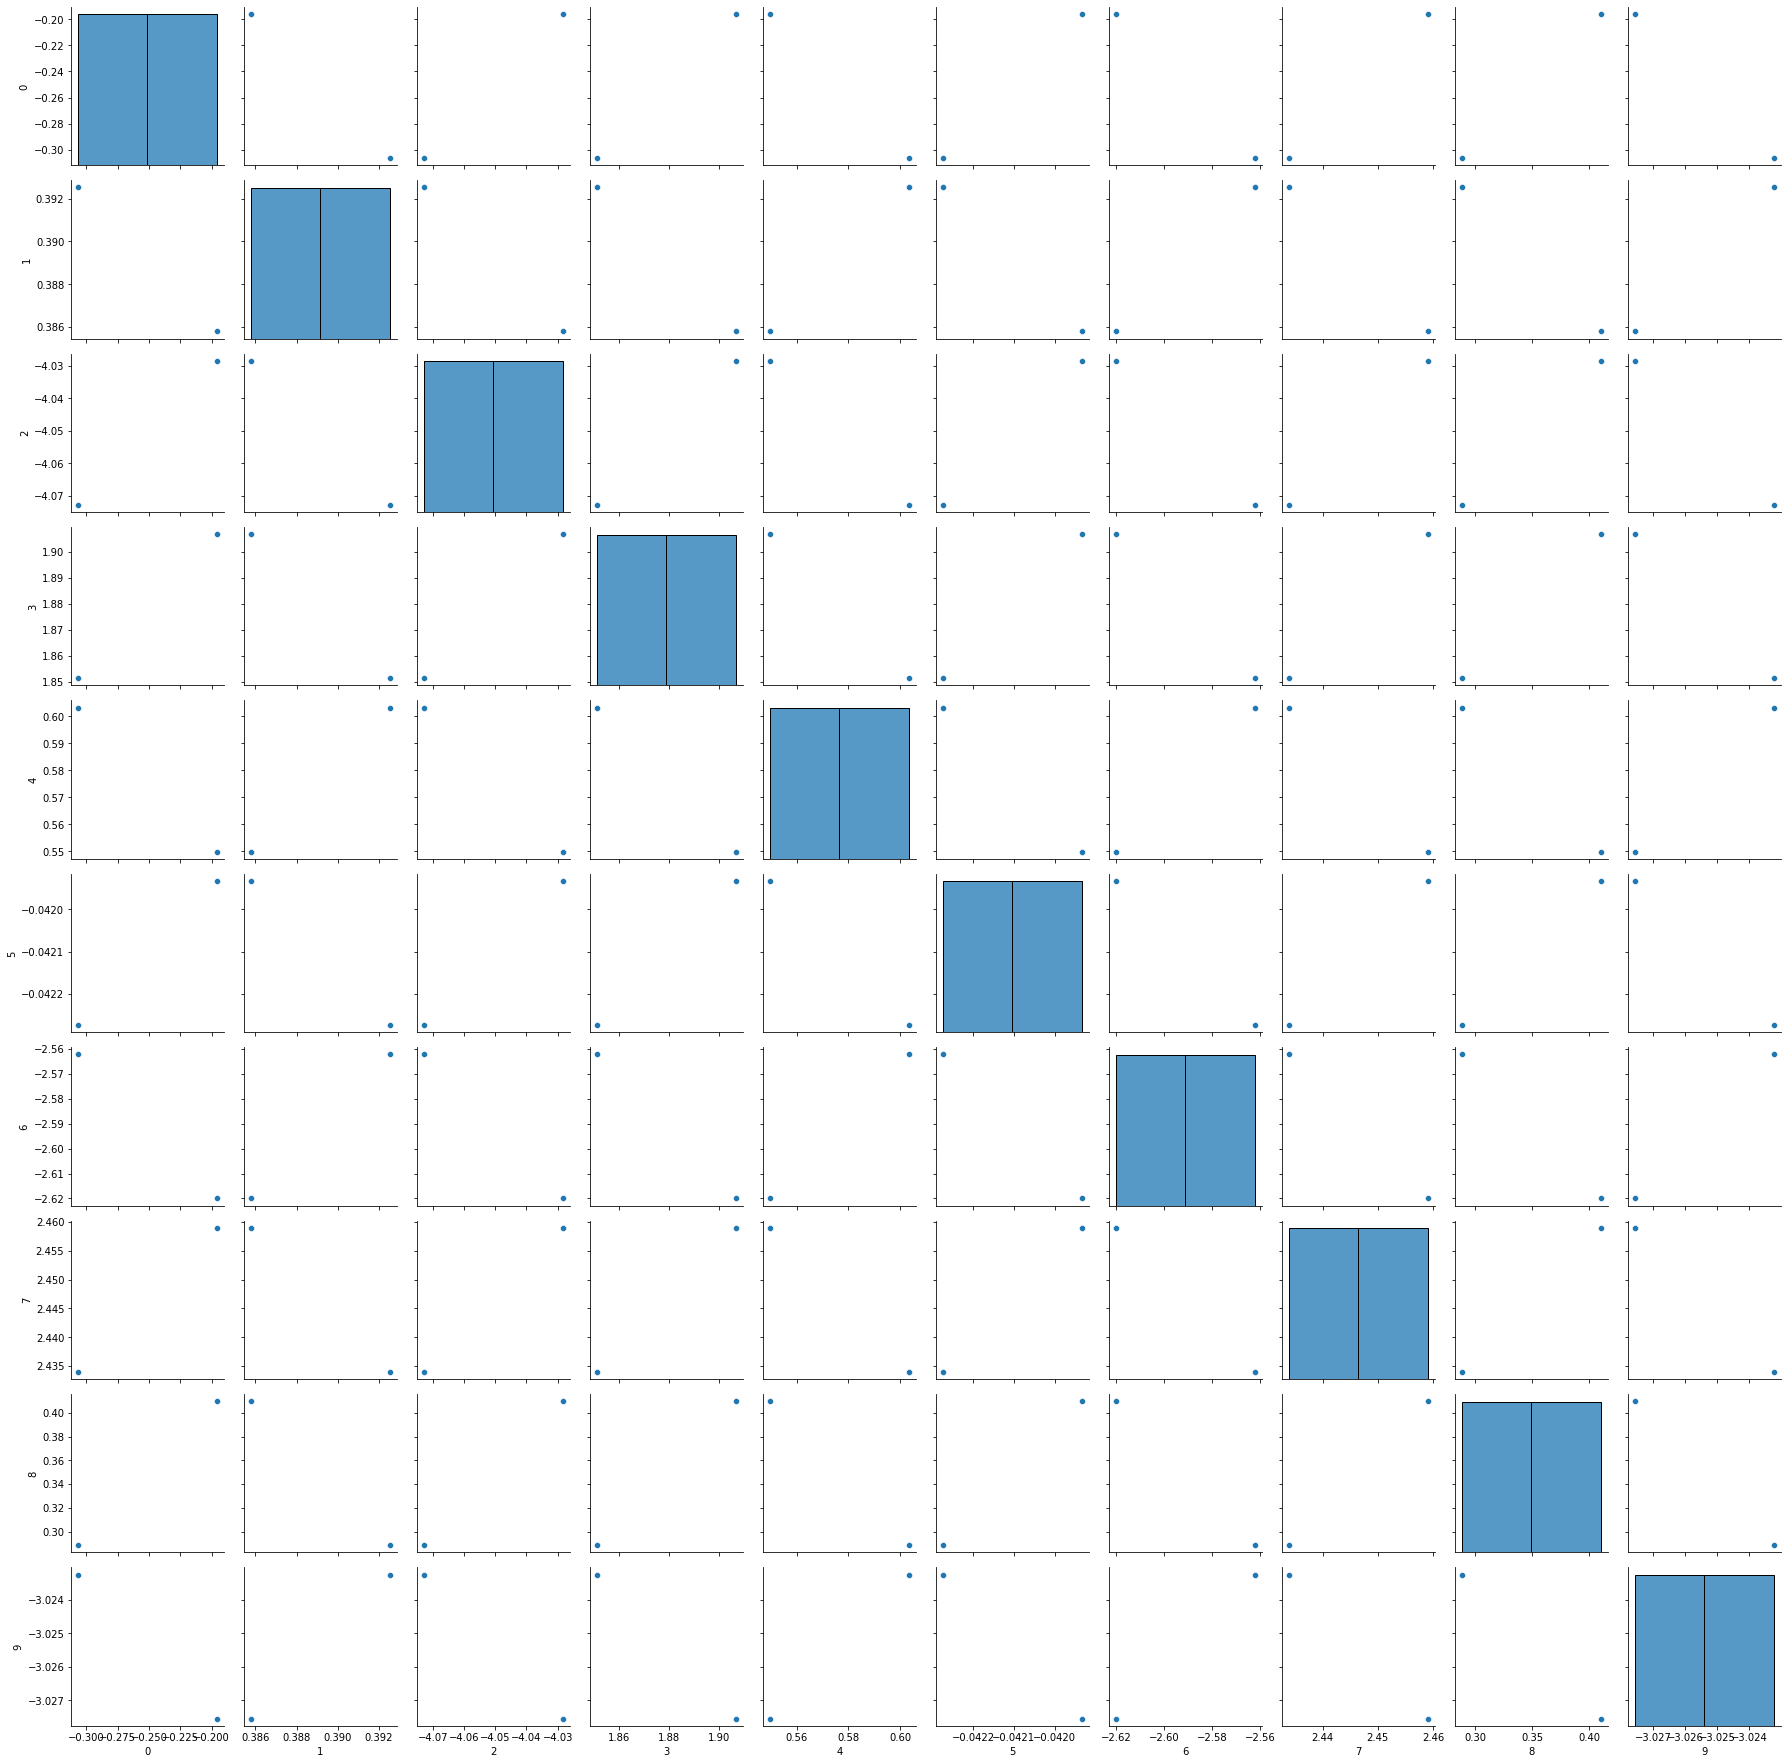

In [10]:
import seaborn as sns
import pandas as pd
dim_displayed = 10
perm = torch.randperm(number_param)
g = sns.PairGrid(pd.DataFrame(samples[:,perm][:,:dim_displayed].detach().numpy()))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)